## Global settings

In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from fa2 import ForceAtlas2

root_path = r'Data\TradeData'

clist = ['#720320', '#c6423e', '#f7b89b', 'gray', '#a9d1e5', '#3885bc', '#063264']
newcmp = LinearSegmentedColormap.from_list('mylist', clist)
gradient = np.linspace(0.6, 1.4, 201)
gradient = np.vstack((gradient, gradient, gradient, gradient, gradient, gradient, gradient, gradient))

def get_dictvalues(dict_g):
    return [v for v in dict_g]

def GetLongExport(year, month):
    filename = os.path.join(root_path, 'exportX{0}M{1}.csv'.format(year, month))
    export = pd.read_csv(filename).\
        rename(columns = {'Unnamed: 0': 'from'}).\
        melt(id_vars = 'from', var_name = 'to', value_name = 'export').\
        query('`from` != `to`').\
        reset_index(drop = True)
    export['year'] = year
    export['month'] = month
    return export

def GetLongExports(years, months = None):
    if months is None:
        months = list(range(1, 13)) * len(years)
        years_new = []
        for year in years:
            years_new.extend([year] * 12)
        years = years_new
    exports = []
    for year, month in zip(years, months):
        exports.append(GetLongExport(year, month))
    return pd.concat(exports).reset_index(drop = True)

def MaxPartner(years, months = None):
    export = GetLongExports(years, months).\
        groupby(['from', 'to']).\
        agg({
            'export': np.mean
        }).\
        reset_index()
    trade = export.merge(export, left_on = ['from', 'to'], right_on = ['to', 'from'])
    trade['trade'] = trade['export_x'] + trade['export_y']
    trade = trade[trade['from_x'].isin(AreasFullName) & trade['to_x'].isin(AreasFullName)].\
        reset_index(drop = True)
    index = trade.\
        groupby('from_x')['trade'].\
        idxmax()
    top20trade = trade.\
        loc[index].\
        reset_index(drop = True).\
        drop(columns = {'from_y', 'to_y', 'export_x', 'export_y'}).\
        rename(columns = {'from_x': 'x', 'to_x': 'y'})
    return top20trade

def MaxExportTo(years, months = None):
    export = GetLongExports(years, months).\
        groupby(['from', 'to']).\
        agg({
            'export': np.mean
        }).\
        reset_index()
    export = export[export['from'].isin(AreasFullName)].\
        reset_index(drop = True)
    index = export.\
        groupby('from')['export'].\
        idxmax()
    return export.loc[index].reset_index(drop = True)

def MaxImportFrom(years, months = None):
    export = GetLongExports(years, months).\
        groupby(['from', 'to']).\
        agg({
            'export': np.mean
        }).\
        reset_index()
    export = export[export['to'].isin(AreasFullName)].\
        reset_index(drop = True)
    index = export.\
        groupby('to')['export'].\
        idxmax()
    return export.loc[index].reset_index(drop = True)


In [2]:
AreasGdp = pd.read_excel('Data/GDP2019.xlsx', sheet_name = 'area')
TradeKeys = pd.read_excel('Data/Keys.xlsx', sheet_name = 'TradeNameToISO3')
ISO3ToGdp = dict(zip(AreasGdp['ISO3'], AreasGdp['gdp']))
ISO3ToTradeName = dict(zip(TradeKeys['ISO3'], TradeKeys['TradeName']))
TradeNameToISO3 = dict(zip(TradeKeys['TradeName'], TradeKeys['ISO3']))
Areas = AreasGdp.\
    sort_values('gdp', ascending = False).\
    reset_index(drop = True).\
    loc[:19]['ISO3'].\
    tolist()
AreasFullName = [ISO3ToTradeName[iso3] for iso3 in Areas]

## Export

In [3]:
def GenerateGraphData(data):
    GraphData = max_export_2018to2019.\
        merge(data, on = ['from', 'to'], how = 'right').\
        merge(export_2018to2019, on = ['from', 'to'], how = 'left')
    GraphData['new'] = np.isnan(GraphData['export_x'])
    GraphData = GraphData.\
        drop(columns = ['export_x']).\
        rename(columns = {'export_y': 'export_now', 'export': 'export_before'})
    GraphData['width'] = GraphData['export_now'] / GraphData['export_before']
    return GraphData.drop(columns = ['export_now', 'export_before'])

def get_graph(GraphData):
    G = nx.MultiDiGraph()
    for i in range(len(Areas)):
        G.add_node(Areas[i], gdp = ISO3ToGdp[Areas[i]])
        
    for i in range(GraphData.shape[0]):
        Gdata = GraphData.iloc[i]
        G.add_edge(TradeNameToISO3[Gdata['from']], TradeNameToISO3[Gdata['to']], 
                   width = Gdata['width'], new = (lambda x: 4 if x else 1)(Gdata['new']))
    return G

max_export_2018to2019 = MaxExportTo([2018, 2019])
max_export_2020_4to5 = MaxExportTo([2020] * 2, [4, 5])
max_export_2020_9 = MaxExportTo([2020], [9])
max_export_2021_11to12 = MaxExportTo([2021] * 2, [11, 12])

export_2018to2019 = GetLongExports([2018, 2019]).\
    groupby(['from', 'to']).\
    agg({
        'export': np.mean
    }).\
    reset_index()

GraphData_export_2018to2019 = max_export_2018to2019.drop(columns = ['export'])
GraphData_export_2018to2019['new'] = False
GraphData_export_2018to2019['width'] = 1
GraphData_export_2020_4to5 = GenerateGraphData(max_export_2020_4to5)
GraphData_export_2020_9 = GenerateGraphData(max_export_2020_9)
GraphData_export_2021_11to12 = GenerateGraphData(max_export_2021_11to12)

Graph_export_2018to2019 = get_graph(GraphData_export_2018to2019)
Graph_export_2020_4to5 = get_graph(GraphData_export_2020_4to5)
Graph_export_2020_9 = get_graph(GraphData_export_2020_9)
Graph_export_2021_11to12 = get_graph(GraphData_export_2021_11to12)

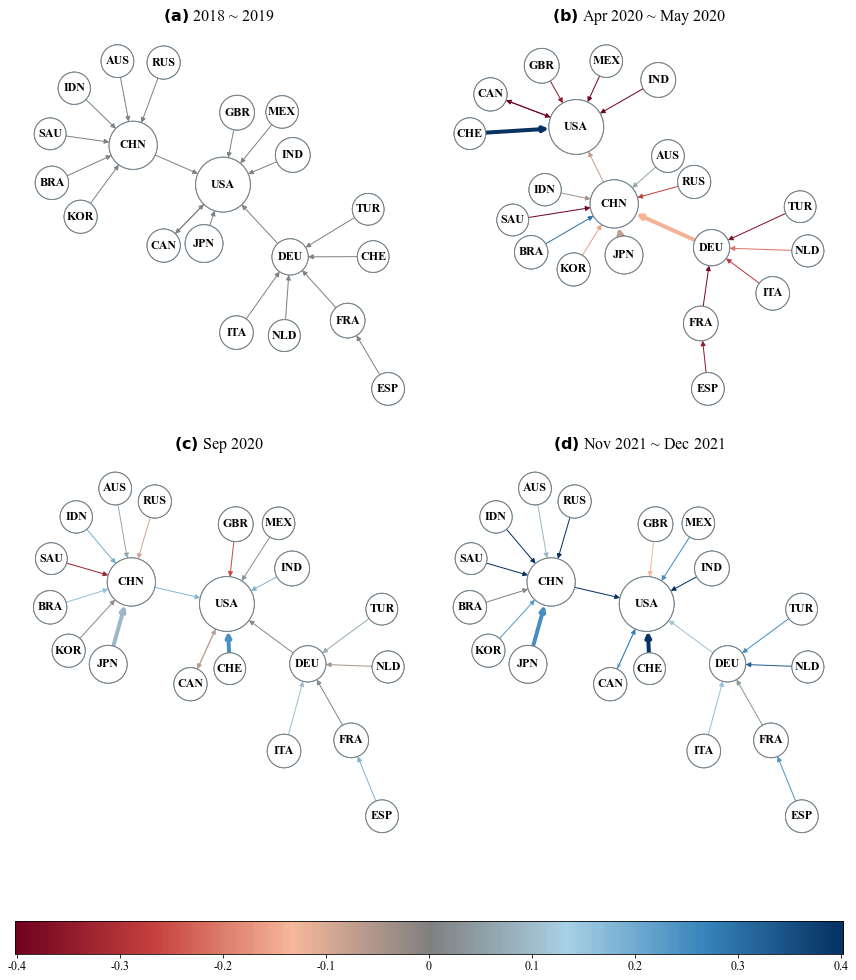

In [4]:
fig, axes = plt.subplots(2, 2, figsize = (12, 14))

size = AreasGdp.sort_values('gdp', ascending = False).\
    reset_index(drop = True)['gdp'].\
    loc[:19]
size = ((size) - (size).min()) / ((size).max() - (size).min()) * 2000 + 1000

plt.subplot2grid((7, 6), (0, 0), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_export_2018to2019, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_export_2018to2019, 'new').values())

nx.draw(Graph_export_2018to2019, pos = nx.nx_pydot.graphviz_layout(Graph_export_2018to2019),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4,
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_export_2018to2019, pos = nx.nx_pydot.graphviz_layout(Graph_export_2018to2019),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(a)}$ 2018 ~ 2019', fontsize = 16)

plt.subplot2grid((7, 6), (0, 3), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_export_2020_4to5, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_export_2020_4to5, 'new').values())

nx.draw(Graph_export_2020_4to5, pos = nx.nx_pydot.graphviz_layout(Graph_export_2020_4to5),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4, 
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_export_2020_4to5, pos = nx.nx_pydot.graphviz_layout(Graph_export_2020_4to5),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(b)}$ Apr 2020 ~ May 2020', fontsize = 16)

plt.subplot2grid((7, 6), (3, 0), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_export_2020_9, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_export_2020_9, 'new').values())

nx.draw(Graph_export_2020_9, pos = nx.nx_pydot.graphviz_layout(Graph_export_2020_9),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4, 
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_export_2020_9, pos = nx.nx_pydot.graphviz_layout(Graph_export_2020_9),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(c)}$ Sep 2020', fontsize = 16)

plt.subplot2grid((7, 6), (3, 3), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_export_2021_11to12, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_export_2021_11to12, 'new').values())

nx.draw(Graph_export_2021_11to12, pos = nx.nx_pydot.graphviz_layout(Graph_export_2021_11to12),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4, 
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_export_2021_11to12, pos = nx.nx_pydot.graphviz_layout(Graph_export_2021_11to12),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(d)}$ Nov 2021 ~ Dec 2021', fontsize = 16)

plt.subplot2grid((7, 6), (6, 0), colspan = 6)
plt.imshow(gradient, interpolation = 'none', cmap = newcmp, origin = 'lower')
plt.yticks([])
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 200], [-0.4, -0.3, -0.2, -0.1,  0,  0.1,  0.2,  0.3,  0.4], fontsize = 12)

plt.rcParams['font.sans-serif'] = 'Times New Roman'

fig.tight_layout()
fig.savefig(r'Plots/Figure 5.jpg', bbox_inches = 'tight', dpi = 300)

## Import

In [5]:
def GenerateGraphData(data):
    GraphData = max_import_2018to2019.\
        merge(data, on = ['from', 'to'], how = 'right').\
        merge(export_2018to2019, on = ['from', 'to'], how = 'left')
    GraphData['new'] = np.isnan(GraphData['export_x'])
    GraphData = GraphData.\
        drop(columns = ['export_x']).\
        rename(columns = {'export_y': 'export_now', 'export': 'export_before'})
    GraphData['width'] = GraphData['export_now'] / GraphData['export_before']
    return GraphData.drop(columns = ['export_now', 'export_before'])

def get_graph(GraphData):
    G = nx.MultiDiGraph()
    for i in range(len(Areas)):
        G.add_node(Areas[i], gdp = ISO3ToGdp[Areas[i]])
        
    for i in range(GraphData.shape[0]):
        Gdata = GraphData.iloc[i]
        G.add_edge(TradeNameToISO3[Gdata['from']], TradeNameToISO3[Gdata['to']], 
                   width = Gdata['width'], new = (lambda x: 4 if x else 1)(Gdata['new']))
    return G

max_import_2018to2019 = MaxImportFrom([2018, 2019])
max_import_2020_4to5 = MaxImportFrom([2020] * 2, [4, 5])
max_import_2020_9 = MaxImportFrom([2020], [9])
max_import_2021_11to12 = MaxImportFrom([2021] * 2, [11, 12])

import_2018to2019 = GetLongExports([2018, 2019]).\
    groupby(['from', 'to']).\
    agg({
        'export': np.mean
    }).\
    reset_index()

GraphData_import_2018to2019 = max_import_2018to2019.drop(columns = ['export'])
GraphData_import_2018to2019['new'] = False
GraphData_import_2018to2019['width'] = 1
GraphData_import_2020_4to5 = GenerateGraphData(max_import_2020_4to5)
GraphData_import_2020_9 = GenerateGraphData(max_import_2020_9)
GraphData_import_2021_11to12 = GenerateGraphData(max_import_2021_11to12)

Graph_import_2018to2019 = get_graph(GraphData_import_2018to2019)
Graph_import_2020_4to5 = get_graph(GraphData_import_2020_4to5)
Graph_import_2020_9 = get_graph(GraphData_import_2020_9)
Graph_import_2021_11to12 = get_graph(GraphData_import_2021_11to12)

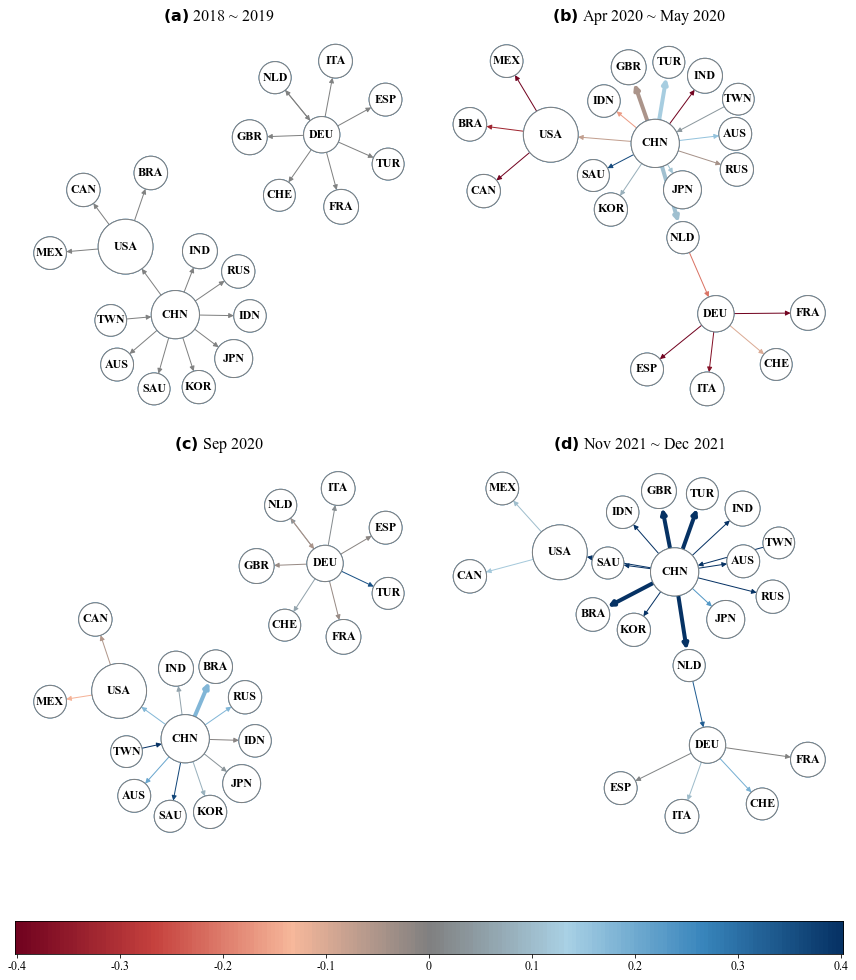

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (12, 14))

size = AreasGdp.sort_values('gdp', ascending = False).\
    reset_index(drop = True)['gdp'].\
    loc[:20]
size = ((size) - (size).min()) / ((size).max() - (size).min()) * 2000 + 1000

plt.subplot2grid((7, 6), (0, 0), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_import_2018to2019, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_import_2018to2019, 'new').values())

nx.draw(Graph_import_2018to2019, pos = nx.nx_pydot.graphviz_layout(Graph_import_2018to2019),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4,
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_import_2018to2019, pos = nx.nx_pydot.graphviz_layout(Graph_import_2018to2019),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(a)}$ 2018 ~ 2019', fontsize = 16)

plt.subplot2grid((7, 6), (0, 3), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_import_2020_4to5, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_import_2020_4to5, 'new').values())

nx.draw(Graph_import_2020_4to5, pos = nx.nx_pydot.graphviz_layout(Graph_import_2020_4to5),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4, 
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_import_2020_4to5, pos = nx.nx_pydot.graphviz_layout(Graph_import_2020_4to5),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(b)}$ Apr 2020 ~ May 2020', fontsize = 16)

plt.subplot2grid((7, 6), (3, 0), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_import_2020_9, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_import_2020_9, 'new').values())

nx.draw(Graph_import_2020_9, pos = nx.nx_pydot.graphviz_layout(Graph_import_2020_9),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4, 
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_import_2020_9, pos = nx.nx_pydot.graphviz_layout(Graph_import_2020_9),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(c)}$ Sep 2020', fontsize = 16)

plt.subplot2grid((7, 6), (3, 3), colspan = 3, rowspan = 3)
color = nx.get_edge_attributes(Graph_import_2021_11to12, 'width').values()
width = get_dictvalues(nx.get_edge_attributes(Graph_import_2021_11to12, 'new').values())

nx.draw(Graph_import_2021_11to12, pos = nx.nx_pydot.graphviz_layout(Graph_import_2021_11to12),
        with_labels = True, edge_color = color, width = width,
        edge_cmap = newcmp, edge_vmin = 0.6, edge_vmax = 1.4, 
        node_size = size,
        font_family = 'Times New Roman', font_color = 'black', font_weight = 'bold')
nx.draw_networkx_nodes(Graph_import_2021_11to12, pos = nx.nx_pydot.graphviz_layout(Graph_import_2021_11to12),
                       edgecolors = 'grey', node_color = 'white', node_size = size)
plt.title(r'$\bf{(d)}$ Nov 2021 ~ Dec 2021', fontsize = 16)

plt.subplot2grid((7, 6), (6, 0), colspan = 6)
plt.imshow(gradient, interpolation = 'none', cmap = newcmp, origin = 'lower')
plt.yticks([])
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175, 200], [-0.4, -0.3, -0.2, -0.1,  0,  0.1,  0.2,  0.3,  0.4], fontsize = 12)

plt.rcParams['font.sans-serif'] = 'Times New Roman'

fig.tight_layout()
fig.savefig(r'Plots/Figure 6.jpg', bbox_inches = 'tight', dpi = 300)